In [2]:
# --- Imports ---
import os
import re
import pandas as pd
import numpy as np
import tiktoken
import matplotlib.pyplot as plt
import nltk # For NLTK downloads if needed
from tqdm.notebook import tqdm # For progress bars in notebooks

# --- NLTK Downloads 
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')



In [ ]:
import os
import re
import pandas as pd
import numpy as np
import tiktoken
import nltk
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from typing import List, Dict, Optional
import textwrap 

In [ ]:
ITEM_NAME_MAP_10K = {
    "1": "Business", 
    "1A": "Risk Factors", 
    "1B": "Unresolved Staff Comments", 
    "1C": "Cybersecurity",
    "2": "Properties", 
    "3": "Legal Proceedings", 
    "4": "Mine Safety Disclosures",
    "5": "Market for Registrant's Common Equity, Related Stockholder Matters and Issuer Purchases of Equity Securities",
    "6": "Reserved", 
    "7": "Management's Discussion and Analysis of Financial Condition and Results of Operations",
    "7A": "Quantitative and Qualitative Disclosures About Market Risk", 
    "8": "Financial Statements and Supplementary Data",
    "9": "Changes in and Disagreements With Accountants on Accounting and Financial Disclosure", 
    "9A": "Controls and Procedures",
    "9B": "Other Information", 
    "9C": "Disclosure Regarding Foreign Jurisdictions that Prevent Inspections",
    "10": "Directors, Executive Officers and Corporate Governance", 
    "11": "Executive Compensation",
    "12": "Security Ownership of Certain Beneficial Owners and Management and Related Stockholder Matters",
    "13": "Certain Relationships and Related Transactions, and Director Independence", 
    "14": "Principal Accountant Fees and Services",
    "15": "Exhibits, Financial Statement Schedules", 
    "16": "Form 10-K Summary"
}

ITEM_NAME_MAP_10Q_PART_I = {
    "1": "Financial Statements",
    "2": "Management's Discussion and Analysis of Financial Condition and Results of Operations",
    "3": "Quantitative and Qualitative Disclosures About Market Risk",
    "4": "Controls and Procedures",
}

ITEM_NAME_MAP_10Q_PART_II = {
    "1": "Legal Proceedings", "1A": "Risk Factors",
    "2": "Unregistered Sales of Equity Securities and Use of Proceeds",
    "3": "Defaults Upon Senior Securities", "4": "Mine Safety Disclosures",
    "5": "Other Information", "6": "Exhibits",
}



# --- Configuration ---
data_path = "../processed_filings" 

# Initialize tokenizer for accurate token counting
encoding = tiktoken.encoding_for_model("text-embedding-3-small")

In [8]:
file_stats = []
print("Analyzing raw filing files (size, lines, chars)...")
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".txt"):
            path = os.path.join(root, file)
            size = os.path.getsize(path)
            with open(path, "r", encoding="utf-8") as f:
                lines = f.readlines()
                num_lines = len(lines)
                num_chars = sum(len(line) for line in lines)
            file_stats.append({
                "filename": path,
                "size_bytes": size,
                "num_lines": num_lines,
                "num_chars": num_chars
            })
df_raw_stats = pd.DataFrame(file_stats)
print("\n--- Raw File Statistics Summary ---")
display(df_raw_stats.describe())
display(df_raw_stats.head())

Analyzing raw filing files (size, lines, chars)...

--- Raw File Statistics Summary ---


,size_bytes,num_lines,num_chars
count,174.000000,174.000000,174.000000
mean,239951.591954,1836.402299,238285.172414
std,132959.003584,842.820903,132707.124152
min,61315.000000,657.000000,60725.000000
25%,134642.250000,1239.500000,128642.750000
50%,218271.000000,1562.000000,217526.000000
75%,318432.250000,2308.500000,316440.000000
max,699356.000000,4815.000000,697372.000000


,filename,size_bytes,num_lines,num_chars
0,../processed_filings/AMZN/AMZN_10Q_2022-04-29.txt,167245,1341,166439
1,../processed_filings/AMZN/AMZN_10Q_2020-05-01.txt,167123,1487,166417
2,../processed_filings/AMZN/AMZN_10Q_2020-10-30.txt,167455,1315,166715
3,../processed_filings/AMZN/AMZN_10Q_2024-08-02.txt,180131,1373,179300
4,../processed_filings/AMZN/AMZN_10Q_2021-04-30.txt,156400,1307,155702


In [11]:
tickers = ["AAPL", "AMZN", "FL", "KO", "META", "MSFT", "NVDA", "TSLA"] # Companies in your dataset
token_stats_list = []

print("\nAnalyzing files for token counts...")
for ticker in tqdm(tickers, desc="Processing companies for token counts"):
    company_path = os.path.join(data_path, ticker)
    if not os.path.isdir(company_path):
        continue
    for filename in os.listdir(company_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(company_path, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
            
            form_type = ""
            if "_10K_" in filename:
                form_type = "10K"
            elif "_10Q_" in filename:
                form_type = "10Q"
            else:
                continue

            parts = filename.replace(".txt", "").split('_')
            file_ticker = parts[0]
            filing_date = parts[2]

            token_stats_list.append({
                "Filename": filename,
                "Ticker": file_ticker,
                "Form Type": form_type,
                "Filing Date": filing_date,
                "Tokens": len(encoding.encode(content)),
            })
print("Token count analysis complete.")

df_token_stats = pd.DataFrame(token_stats_list)
print(df_token_stats.head())



Analyzing files for token counts...


Processing companies for token counts:   0%|          | 0/8 [00:00<?, ?it/s]

Token count analysis complete.
                  Filename Ticker Form Type Filing Date  Tokens
0  AAPL_10Q_2023-08-04.txt   AAPL       10Q  2023-08-04   17711
1  AAPL_10Q_2020-01-29.txt   AAPL       10Q  2020-01-29   26690
2  AAPL_10Q_2024-02-02.txt   AAPL       10Q  2024-02-02   15244
3  AAPL_10Q_2021-07-28.txt   AAPL       10Q  2021-07-28   28534
4  AAPL_10Q_2025-01-31.txt   AAPL       10Q  2025-01-31   16215


In [14]:
print("\n--- Aggregate Statistics for 10-K Filings (Tokens) ---")
df_10k_tokens = df_token_stats[df_token_stats["Form Type"] == "10K"]
display(df_10k_tokens[['Tokens']].describe())

print("\n--- Aggregate Statistics for 10-Q Filings (Tokens) ---")
df_10q_tokens = df_token_stats[df_token_stats["Form Type"] == "10Q"] 
display(df_10q_tokens[['Tokens']].describe())


--- Aggregate Statistics for 10-K Filings (Tokens) ---


,Tokens
count,46.000000
mean,83540.869565
std,26605.646744
min,46668.000000
25%,63778.250000
50%,77131.500000
75%,94487.750000
max,149948.000000



--- Aggregate Statistics for 10-Q Filings (Tokens) ---


,Tokens
count,128.000000
mean,40789.710938
std,15499.258313
min,15244.000000
25%,29096.000000
50%,38440.500000
75%,51634.750000
max,75098.000000


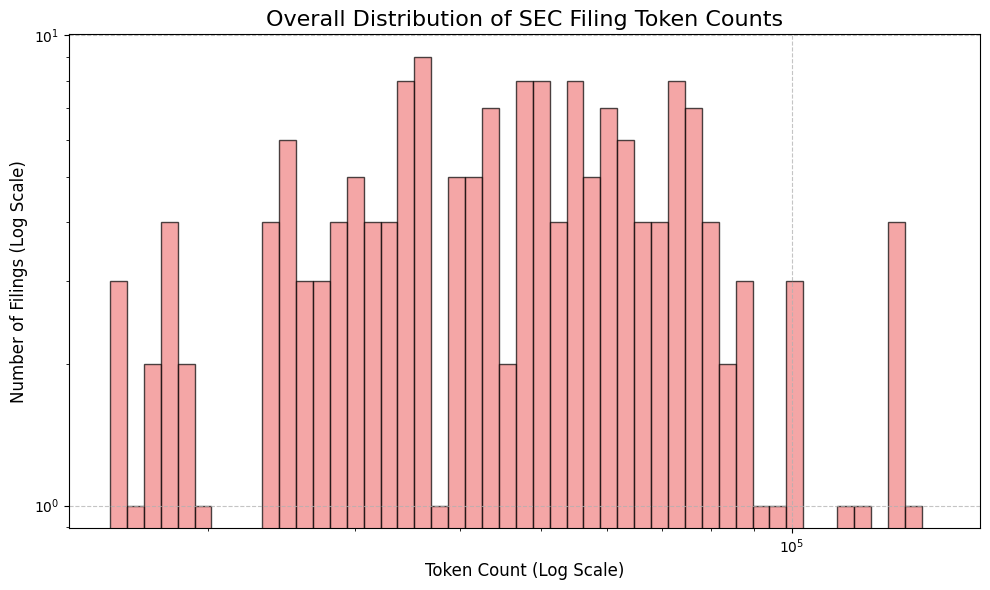

In [15]:
plt.figure(figsize=(10, 6))
# Using logarithmic bins for token counts
bins = np.logspace(np.log10(df_token_stats['Tokens'].min()), np.log10(df_token_stats['Tokens'].max()), 50)
plt.hist(df_token_stats['Tokens'], bins=bins, color='lightcoral', edgecolor='black', alpha=0.7)
plt.xscale('log') # Logarithmic scale for x-axis
plt.yscale('log') # Logarithmic scale for y-axis (number of filings)
plt.title('Overall Distribution of SEC Filing Token Counts', fontsize=16)
plt.xlabel('Token Count (Log Scale)', fontsize=12)
plt.ylabel('Number of Filings (Log Scale)', fontsize=12)
plt.grid(axis='both', alpha=0.75, linestyle='--')
plt.tight_layout()
plt.show()

In [13]:
print("\n--- Filings in Upper Quartile by Token Count ---")
upper_quartile_threshold = df_token_stats['Tokens'].quantile(0.75)
print(f"Upper Quartile (75th percentile) starts at: {int(upper_quartile_threshold)} tokens")
df_upper_quartile = df_token_stats[df_token_stats['Tokens'] >= upper_quartile_threshold].sort_values(by='Tokens', ascending=False).reset_index(drop=True)
display(df_upper_quartile[['Filename', 'Tokens']])


--- Filings in Upper Quartile by Token Count ---
Upper Quartile (75th percentile) starts at: 65891 tokens


,Filename,Tokens
0,KO_10K_2020-02-24.txt,149948
1,KO_10K_2021-02-25.txt,140254
2,KO_10K_2022-02-22.txt,133537
3,KO_10K_2023-02-21.txt,132188
4,KO_10K_2025-02-20.txt,131523
5,KO_10K_2024-02-20.txt,131394
6,TSLA_10K_2020-02-13.txt,121376
7,TSLA_10K_2021-02-08.txt,114465
8,META_10K_2025-01-30.txt,102281
9,META_10K_2024-02-02.txt,100704


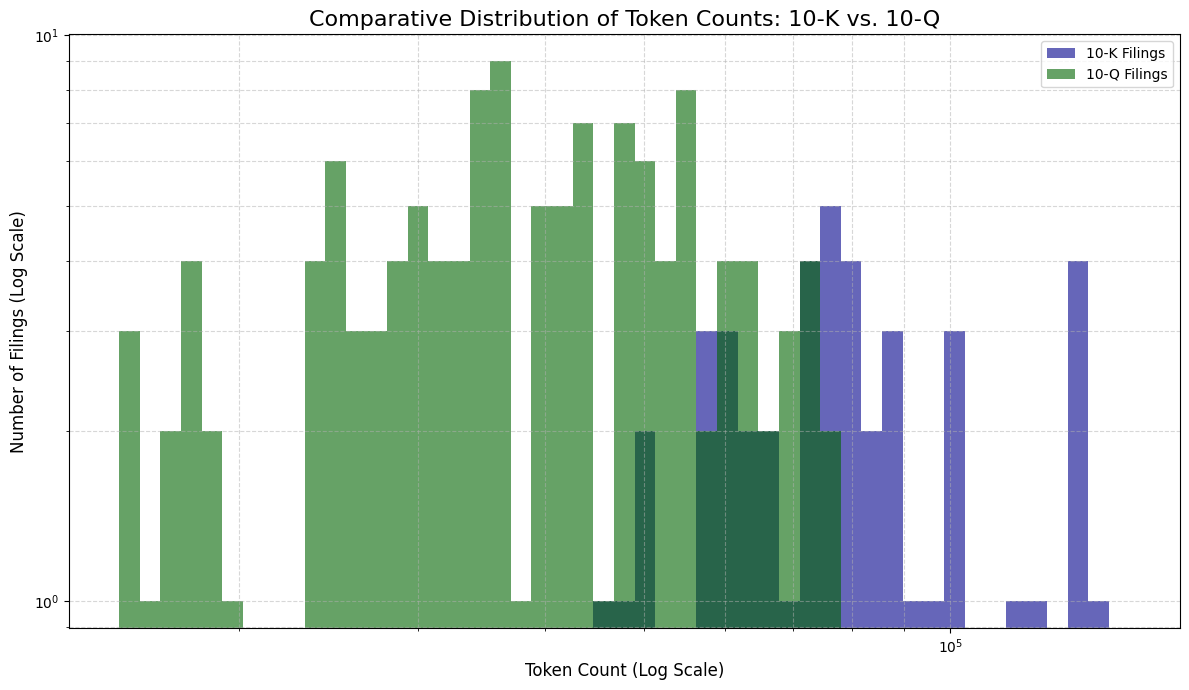

In [16]:
plt.figure(figsize=(12, 7))
# Use common logarithmic bins for both distributions
min_tokens_overall = df_token_stats['Tokens'].min()
max_tokens_overall = df_token_stats['Tokens'].max()
bins = np.logspace(np.log10(min_tokens_overall), np.log10(max_tokens_overall), 50)

plt.hist(df_10k_tokens['Tokens'], bins=bins, color='darkblue', alpha=0.6, label='10-K Filings')
plt.hist(df_10q_tokens['Tokens'], bins=bins, color='darkgreen', alpha=0.6, label='10-Q Filings')

plt.xscale('log')
plt.yscale('log')
plt.title('Comparative Distribution of Token Counts: 10-K vs. 10-Q', fontsize=16)
plt.xlabel('Token Count (Log Scale)', fontsize=12)
plt.ylabel('Number of Filings (Log Scale)', fontsize=12)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()


# Chunking

In [21]:
# --- Helper Functions ---
def clean_chunk_text(text):
    """Removes leftover artifacts and cleans up whitespace."""
    text = text.replace("[TABLE_START]", "").replace("[TABLE_END]", "")
    text = text.replace("[PAGE BREAK]", "")
    text = re.sub(r'\n\s*\n', '\n', text)
    text = re.sub(r' +', ' ', text)
    return text.strip()

# --- Main Processing Function with Robust Parsing ---
def final_process_filing_with_metadata(file_path, min_tokens=25, target_size=500, tolerance=100):
    """
    Processes a single SEC filing with a robust strategy to correctly identify
    all document sections and create well-structured chunks.
    """
    encoding = tiktoken.encoding_for_model("text-embedding-3-small")
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    filename = os.path.basename(file_path)
    file_id = filename.replace(".txt", "")
    parts = file_id.split('_')
    ticker, form_type, filing_date_str = parts[0], parts[1], parts[2]

    # --- Derive Temporal Metadata ---
    filing_date = pd.to_datetime(filing_date_str)
    fiscal_year = filing_date.year
    fiscal_quarter = filing_date.quarter
    if form_type == '10K' and filing_date.month < 4:
        fiscal_year -= 1

    # --- Robust Structural Parsing using finditer ---
    section_pattern = re.compile(
        r'(?i)(^\s*PART\s+I[V|X]*\b|^\s*ITEM\s+\d{1,2}[A-Z]?\b)',
        re.MULTILINE
    )
    
    matches = list(section_pattern.finditer(content))
    
    if not matches:
        return []

    sections = []
    intro_text = content[:matches[0].start()].strip()
    if intro_text:
        sections.append(("Intro", intro_text))

    for i, match in enumerate(matches):
        start_pos = match.start()
        end_pos = matches[i+1].start() if i + 1 < len(matches) else len(content)
        section_title = match.group(0).strip()
        section_text = content[start_pos:end_pos].strip()
        sections.append((section_title, section_text))

    # --- Process each identified section ---
    temp_chunks = []
    current_part = "PART I" 

    for section_title, section_text in sections:
        
        if "PART" in section_title.upper():
            current_part = section_title.upper()
            if form_type == '10Q':
                item_map = ITEM_NAME_MAP_10Q_PART_I if current_part == "PART I" else ITEM_NAME_MAP_10Q_PART_II
                item_name = item_map.get("1", "Unknown Section")
                item_id = f"{current_part}, Item 1 - {item_name}"
            else: # It's a 10-K
                item_name = ITEM_NAME_MAP_10K.get("1", "Unknown Section")
                item_id = f"Item 1 - {item_name}"

        elif "ITEM" in section_title.upper():
            item_id_match = re.search(r'(\d{1,2}[A-Z]?)', section_title)
            item_number = item_id_match.group(1).upper() if item_id_match else "Unknown"
            
            if form_type == '10Q':
                if item_number in ITEM_NAME_MAP_10Q_PART_II and item_number not in ITEM_NAME_MAP_10Q_PART_I:
                    current_part = "PART II"
                
                item_map = ITEM_NAME_MAP_10Q_PART_I if current_part == "PART I" else ITEM_NAME_MAP_10Q_PART_II
                item_name = item_map.get(item_number, "Unknown Section")
                item_id = f"{current_part}, Item {item_number} - {item_name}"
            else: # It's a 10-K
                item_map = ITEM_NAME_MAP_10K
                item_name = item_map.get(item_number, "Unknown Section")
                item_id = f"Item {item_number} - {item_name}"
        else:
            item_id = "Intro"

        # --- Table and Narrative Splitting ---
        table_pattern = re.compile(r'\[TABLE_START\].*?\[TABLE_END\]', re.DOTALL)
        table_matches = table_pattern.finditer(section_text)
        for match in table_matches:
            temp_chunks.append({"text": match.group(0).strip(), "chunk_type": "table", "item_id": item_id})
        
        narrative_text = table_pattern.sub('', section_text).strip()
        if narrative_text:
            paragraphs = [p for p in narrative_text.split('\n\n') if p.strip()]
            current_chunk = ""
            for p in paragraphs:
                if len(encoding.encode(current_chunk + p)) > (target_size + tolerance):
                    if current_chunk:
                        temp_chunks.append({"text": current_chunk, "chunk_type": "narrative", "item_id": item_id})
                    current_chunk = p
                else:
                    current_chunk += "\n\n" + p
            if current_chunk:
                temp_chunks.append({"text": current_chunk, "chunk_type": "narrative", "item_id": item_id})

    # --- Final Cleaning, ID Generation, etc. ---
    final_chunks_with_id = []
    for i, chunk_data in enumerate(temp_chunks):
        cleaned_text = clean_chunk_text(chunk_data["text"])
        token_count = len(encoding.encode(cleaned_text))
        
        if token_count >= min_tokens:
            chunk_id = f"{file_id}-chunk-{i:04d}"
            final_chunks_with_id.append({
                "chunk_id": chunk_id, "ticker": ticker, "form_type": form_type,
                "filing_date": filing_date_str, "fiscal_year": fiscal_year,
                "fiscal_quarter": fiscal_quarter, "item_id": chunk_data["item_id"],
                "chunk_type": chunk_data["chunk_type"], "text": cleaned_text,
                "token_count": token_count
            })
            
    return final_chunks_with_id



Analyzing raw filing files (size, lines, chars)...

--- Raw File Statistics Summary ---


,size_bytes,num_lines,num_chars
count,174.000000,174.000000,174.000000
mean,239951.591954,1836.402299,238285.172414
std,132959.003584,842.820903,132707.124152
min,61315.000000,657.000000,60725.000000
25%,134642.250000,1239.500000,128642.750000
50%,218271.000000,1562.000000,217526.000000
75%,318432.250000,2308.500000,316440.000000
max,699356.000000,4815.000000,697372.000000


,filename,size_bytes,num_lines,num_chars
0,../processed_filings/AMZN/AMZN_10Q_2022-04-29.txt,167245,1341,166439
1,../processed_filings/AMZN/AMZN_10Q_2020-05-01.txt,167123,1487,166417
2,../processed_filings/AMZN/AMZN_10Q_2020-10-30.txt,167455,1315,166715
3,../processed_filings/AMZN/AMZN_10Q_2024-08-02.txt,180131,1373,179300
4,../processed_filings/AMZN/AMZN_10Q_2021-04-30.txt,156400,1307,155702



Analyzing files for token counts...
Token count analysis complete.

--- Aggregate Statistics for 10-K Filings (Tokens) ---


,Tokens
count,46.000000
mean,83540.869565
std,26605.646744
min,46668.000000
25%,63778.250000
50%,77131.500000
75%,94487.750000
max,149948.000000



--- Aggregate Statistics for 10-Q Filings (Tokens) ---


,Tokens
count,128.000000
mean,40789.710938
std,15499.258313
min,15244.000000
25%,29096.000000
50%,38440.500000
75%,51634.750000
max,75098.000000



--- Filings in Upper Quartile by Token Count ---
Upper Quartile (75th percentile) starts at: 65891 tokens


,Filename,Tokens
0,KO_10K_2020-02-24.txt,149948
1,KO_10K_2021-02-25.txt,140254
2,KO_10K_2022-02-22.txt,133537
3,KO_10K_2023-02-21.txt,132188
4,KO_10K_2025-02-20.txt,131523
5,KO_10K_2024-02-20.txt,131394
6,TSLA_10K_2020-02-13.txt,121376
7,TSLA_10K_2021-02-08.txt,114465
8,META_10K_2025-01-30.txt,102281
9,META_10K_2024-02-02.txt,100704



Starting final chunking process for all filings...


Processing all filings:   0%|          | 0/174 [00:00<?, ?it/s]



All 174 filings processed with enriched metadata!
Total final chunks created: 26177

--- Sample of Final Chunks with Corrected Metadata ---


,ticker,form_type,filing_date,fiscal_year,fiscal_quarter,item_id,chunk_type,text,token_count
chunk_id,,,,,,,,,
KO_10K_2023-02-21-chunk-0120,KO,10K,2023-02-21,2022,1,Item 7 - Management's Discussion and Analysis ...,narrative,"the Mexican peso and Brazilian real, which had...",573
TSLA_10K_2021-02-08-chunk-0148,TSLA,10K,2021-02-08,2020,1,Item 8 - Financial Statements and Supplementar...,table,"(2) | As of December 31, 2020 and 2019, solar ...",59
AMZN_10Q_2024-11-01-chunk-0052,AMZN,10Q,2024-11-01,2024,4,"PART I, Item 2 - Management's Discussion and A...",table,"Three Months Ended | September 30, | Nine Mont...",145
MSFT_10Q_2025-04-30-chunk-0142,MSFT,10Q,2025-04-30,2025,2,"PART I, Item 2 - Management's Discussion and A...",table,"(In millions, except percentages) | Three Mont...",119
FL_10Q_2022-06-08-chunk-0029,FL,10Q,2022-06-08,2022,2,"PART I, Item 1 - Financial Statements",table,​ | ​ | ​ | ​ | ​ | ​ | ​ | ​ | ​ | ​ | ​ | ​ | ​,25



--- Unique Item IDs Generated ---
Intro
Item 1 - Business
Item 10 - Directors, Executive Officers and Corporate Governance
Item 11 - Executive Compensation
Item 12 - Security Ownership of Certain Beneficial Owners and Management and Related Stockholder Matters
Item 13 - Certain Relationships and Related Transactions, and Director Independence
Item 14 - Principal Accountant Fees and Services
Item 15 - Exhibits, Financial Statement Schedules
Item 16 - Form 10-K Summary
Item 1A - Risk Factors
Item 1B - Unresolved Staff Comments
Item 1C - Cybersecurity
Item 2 - Properties
Item 3 - Legal Proceedings
Item 4 - Mine Safety Disclosures
Item 4A - Unknown Section
Item 5 - Market for Registrant's Common Equity, Related Stockholder Matters and Issuer Purchases of Equity Securities
Item 6 - Reserved
Item 7 - Management's Discussion and Analysis of Financial Condition and Results of Operations
Item 7A - Quantitative and Qualitative Disclosures About Market Risk
Item 8 - Financial Statements and Supp

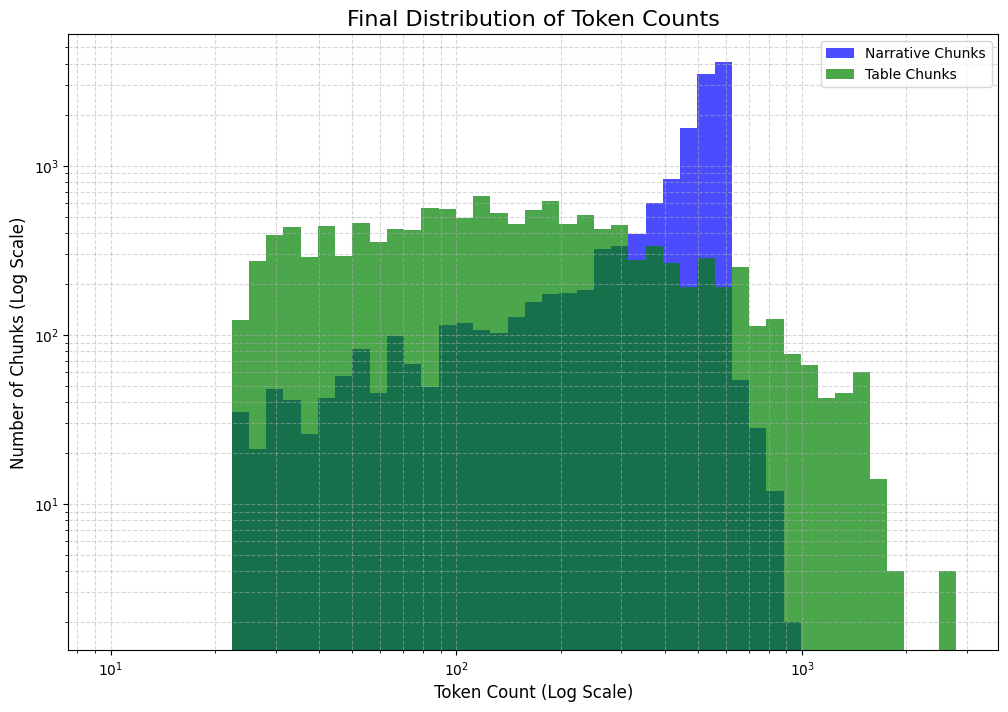

In [20]:
# --- Main Execution Block ---
if __name__ == "__main__":
    # You might need to download NLTK data if you haven't already
    try:
        nltk.data.find('tokenizers/punkt')
    except nltk.downloader.DownloadError:
        nltk.download('punkt')
    try:
        nltk.data.find('corpora/stopwords')
    except nltk.downloader.DownloadError:
        nltk.download('stopwords')

    # Directory containing your SEC filings
    data_path = "../processed_filings/" # Make sure this path is correct

    # --- File Statistics Analysis (from your original notebook) ---
    file_stats = []
    print("Analyzing raw filing files (size, lines, chars)...")
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith(".txt"):
                path = os.path.join(root, file)
                size = os.path.getsize(path)
                with open(path, "r", encoding="utf-8") as f:
                    lines = f.readlines()
                    num_lines = len(lines)
                    num_chars = sum(len(line) for line in lines)
                file_stats.append({
                    "filename": path,
                    "size_bytes": size,
                    "num_lines": num_lines,
                    "num_chars": num_chars
                })
    df_raw_stats = pd.DataFrame(file_stats)
    print("\n--- Raw File Statistics Summary ---")
    display(df_raw_stats.describe())
    display(df_raw_stats.head())

    # --- Token Count Analysis (from your original notebook) ---
    tickers = ["AAPL", "AMZN", "FL", "KO", "META", "MSFT", "NVDA", "TSLA"] # Example tickers
    encoding = tiktoken.encoding_for_model("text-embedding-3-small") # Initialize tokenizer
    token_stats_list = []

    print("\nAnalyzing files for token counts...")
    for ticker in tickers:
        company_path = os.path.join(data_path, ticker)
        if not os.path.isdir(company_path):
            continue
        for filename in os.listdir(company_path):
            if filename.endswith(".txt"):
                file_path = os.path.join(company_path, filename)
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read()
                
                form_type = ""
                if "_10K_" in filename:
                    form_type = "10K"
                elif "_10Q_" in filename:
                    form_type = "10Q"
                else:
                    continue

                parts = filename.replace(".txt", "").split('_')
                file_ticker = parts[0]
                filing_date = parts[2]

                token_stats_list.append({
                    "Filename": filename,
                    "Ticker": file_ticker,
                    "Form Type": form_type,
                    "Filing Date": filing_date,
                    "Tokens": len(encoding.encode(content)),
                })
    print("Token count analysis complete.")

    df_token_stats = pd.DataFrame(token_stats_list)

    print("\n--- Aggregate Statistics for 10-K Filings (Tokens) ---")
    df_10k_tokens = df_token_stats[df_token_stats["Form Type"] == "10K"]
    display(df_10k_tokens[['Tokens']].describe())

    print("\n--- Aggregate Statistics for 10-Q Filings (Tokens) ---")
    df_10q_tokens = df_token_stats[df_token_stats["Form Type"] == "10Q"]
    display(df_10q_tokens[['Tokens']].describe())

    print("\n--- Filings in Upper Quartile by Token Count ---")
    upper_quartile_threshold = df_token_stats['Tokens'].quantile(0.75)
    print(f"Upper Quartile (75th percentile) starts at: {int(upper_quartile_threshold)} tokens")
    df_upper_quartile = df_token_stats[df_token_stats['Tokens'] >= upper_quartile_threshold].sort_values(by='Tokens', ascending=False).reset_index(drop=True)
    display(df_upper_quartile[['Filename', 'Tokens']])

    # --- Core Processing Loop ---
    all_files_chunks = []
    all_filepaths = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(data_path)) for f in fn if f.endswith('.txt')]

    print("\nStarting final chunking process for all filings...")
    for file_path in tqdm(all_filepaths, desc="Processing all filings"):
        all_files_chunks.extend(final_process_filing_with_metadata(file_path))

    df_final_chunks = pd.DataFrame(all_files_chunks)

    print(f"\n\nAll {len(all_filepaths)} filings processed with enriched metadata!")
    print(f"Total final chunks created: {len(df_final_chunks)}\n")

    print("--- Sample of Final Chunks with Corrected Metadata ---")
    display(df_final_chunks.set_index('chunk_id').sample(5))

    print("\n--- Unique Item IDs Generated ---")
    unique_ids = sorted(df_final_chunks['item_id'].unique())
    for uid in unique_ids:
        print(uid)

    # --- Plotting Final Distribution of Token Counts ---
    narrative_tokens = df_final_chunks[df_final_chunks['chunk_type'] == 'narrative']['token_count']
    table_tokens = df_final_chunks[df_final_chunks['chunk_type'] == 'table']['token_count']

    plt.figure(figsize=(12, 8))
    logbins = np.logspace(np.log10(10), np.log10(df_final_chunks['token_count'].max() + 1), 50)
    plt.hist(narrative_tokens, bins=logbins, color='blue', alpha=0.7, label='Narrative Chunks')
    plt.hist(table_tokens, bins=logbins, color='green', alpha=0.7, label='Table Chunks')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Final Distribution of Token Counts', fontsize=16)
    plt.xlabel('Token Count (Log Scale)', fontsize=12)
    plt.ylabel('Number of Chunks (Log Scale)', fontsize=12)
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.show()